In [1]:
# Imports
from __future__ import division
import os,sys
import numpy as np
import scipy.ndimage as ndi
import matplotlib.pyplot as plt

In [2]:
# Parameters
# Note: sizes must be ODD!
x_size     = 101
y_size     = 101
max_breaks = 100     # A uniform random number of breaks between 0 and max_breaks will be inserted into the maze at the end
gen_num    = 1000    # Total number of random mazes to generate
out        = None    # None for not saving, otherwise a name (folders will be "mazes_"+out, files "maze_"+out+"_"+num+".txt")

In [3]:
# Recursive division function
def recursive_divide(x_min,x_max,y_min,y_max,top_level=True):
    
    # Get the chamber shape
    shape = (y_max-y_min, x_max-x_min)
    
    # Detect if the chunk is minimal; if so, you're done
    if shape[0] < 3 or shape[1] < 3:
        return
    
    # Quick function to create 1D normal distribution in array
    # (used in line selection below)
    def normal_array(size):
        normal = np.zeros((size))
        normal[size//2] = 1
        normal = ndi.gaussian_filter1d(normal,size//4)
        return normal
    
    # Select a horizontal and a vertical line at random
    # Note 1: Ensures that only even numbers are possible!
    # Note 2: Using a normal distribution creates nicer mazes,
    #         as they will have fewer long walls... in theory.
    x_options = np.arange(x_min+2,x_max,2)
    x_normal  = normal_array(x_options.size)
    x_line    = np.random.choice(x_options,p=x_normal)
    y_options = np.arange(y_min+2,y_max,2)
    y_normal  = normal_array(y_options.size)
    y_line    = np.random.choice(y_options,p=y_normal)
    
    # Add the lines
    maze[y_line,x_min+1:x_max] = 0
    maze[y_min+1:y_max,x_line] = 0
    
    # Select 3 of the 4 resulting walls
    walls = np.random.choice(np.array([0,1,2,3]),size=3,replace=False)
    
    # Open the doors
    if 0 in walls:  # x_line 1st segment
        door = np.random.choice(np.arange(y_min+1,y_line,2))
        maze[door,x_line] = 1
    if 1 in walls:  # x_line 2nd segment
        door = np.random.choice(np.arange(y_line+1,y_max,2))
        maze[door,x_line] = 1
    if 2 in walls:  # y_line 1st segment
        door = np.random.choice(np.arange(x_min+1,x_line,2))
        maze[y_line,door] = 1
    if 3 in walls:  # y_line 2nd segment
        door = np.random.choice(np.arange(x_line+1,x_max,2))
        maze[y_line,door] = 1
        
    # For each resulting chunk, call the function again
    for chunk in [(x_min,x_line,y_min,y_line),
                  (x_line,x_max,y_min,y_line),
                  (x_min,x_line,y_line,y_max),
                  (x_line,x_max,y_line,y_max)]:
        recursive_divide(*chunk,top_level=False)
        
    # At the end (top level)...
    if top_level:
        
        # Add entrance/exit
        maze[0,1]   = 1
        maze[-1,-2] = 1
        
        # Break some additional walls to make the maze more interesting:
        
        # Number of random walls to break
        breaks = np.random.randint(0,max_breaks,1)
        
        # Make the breaks
        b = 0
        while b < breaks:
            
            # Randomly select a spot
            x_options = np.arange(x_min+2,x_max,2)
            x_target  = np.random.choice(x_options)
            y_options = np.arange(y_min+2,y_max,2)
            y_target  = np.random.choice(y_options)
            
            # If it's a wall...
            if maze[y_target,x_target] == 0:
                
                # And if it is not surrounded by walls...
                surroundings = [maze[y_target+y,x_target+x]==0 for y,x in [(-1,0),(0,-1),(1,0),(0,1)]]
                if False in surroundings:
                
                    # Break it!
                    maze[y_target,x_target] = 1
                    b += 1

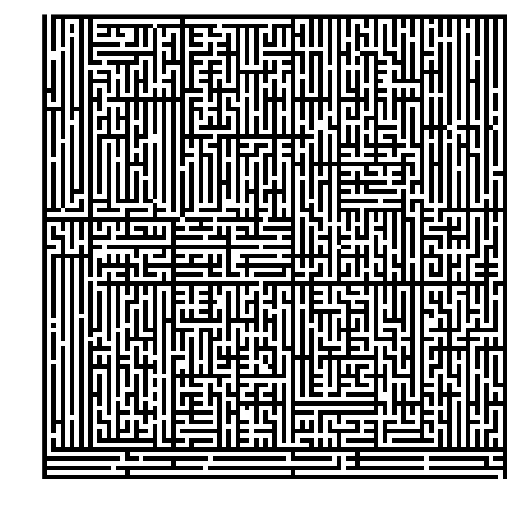

In [4]:
# Running the function once

# Initialize empty array with boundary
maze = np.ones((y_size,x_size),dtype=np.bool)
maze = ndi.binary_erosion(maze,border_value=0)

# Run function
recursive_divide(0,x_size-1,0,y_size-1)

# Show result
plt.figure(figsize=(6,6))
plt.imshow(maze,interpolation='none',cmap='gray')
plt.axis('off')
plt.show()

In [5]:
# Running the function many times

# Initialize result array
num_of_mazes = gen_num
all_mazes = np.zeros((num_of_mazes,y_size,x_size),dtype=np.bool)

# Loop
for maze_index in range(num_of_mazes):
    
    # Initialize empty array with boundary
    maze = np.ones((y_size,x_size),dtype=np.bool)
    maze = ndi.binary_erosion(maze,border_value=0)

    # Run function
    recursive_divide(0,x_size-1,0,y_size-1)
    
    # Add to the result array
    all_mazes[maze_index,:,:] = maze
    
    # Report
    if (maze_index+1) % 100 == 0:
        print "Done with maze:", maze_index+1

Done with maze: 100
Done with maze: 200
Done with maze: 300
Done with maze: 400
Done with maze: 500
Done with maze: 600
Done with maze: 700
Done with maze: 800
Done with maze: 900
Done with maze: 1000


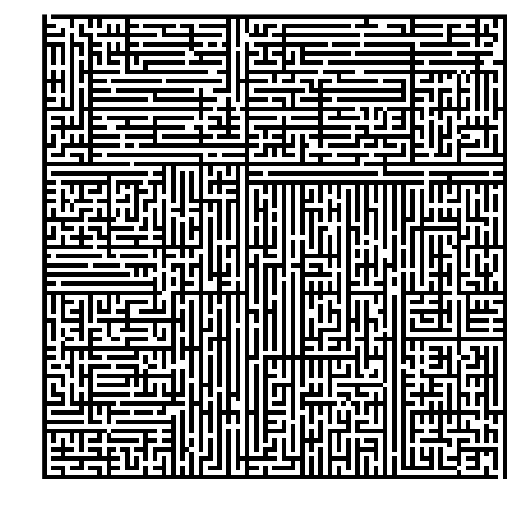

In [6]:
# Displaying the resulting mazes interactively

# Don't display everything if a lot are generated
display_num = 20
if num_of_mazes < 20:
    display_num = num_of_mazes

# Interactive display
from ipywidgets import interact
@interact(maze_index=(0,display_num-1,1))
def sin_plot(maze_index=0):
    plt.figure(figsize=(6,6))
    plt.imshow(all_mazes[maze_index,:,:],interpolation='none',cmap='gray')
    plt.axis('off')
    plt.show()

In [7]:
# Function to check if mazes are solvable and complete
def check_maze(maze):
    
    # Label
    labeled,num_labels = ndi.label(maze)
    
    # # Show
    # plt.imshow(labeled, cmap='winter', interpolation='none')
    # plt.show()
    
    # Check if solvable (both entrances have same label)
    solvable = False
    if maze[0,1] == maze[-1,-2]:
        solvable = True
        
    # Check if complete (all tunnels have same label)
    complete = False
    if num_labels == 1:
        complete = True
    
    return solvable,complete

In [8]:
# Check if all the mazes are solvable and complete

# For each maze
all_solvable, all_complete = (True,True)
for maze_id in range(all_mazes.shape[0]):
    
    # Run check
    s,c = check_maze(all_mazes[0,:,:])
    
    # Remember if it goes wrong at some point
    if not s:
        all_solvable = False
    if not c:
        all_complete = False

# Report
print all_solvable, all_complete

True True


In [9]:
# Write to file
if out is not None:
    outdir  = 'mazes_'+out
    outname = 'maze_'+out+'_'
    os.path.isdir(outdir) or os.mkdir(outdir)
    for maze_id in range(all_mazes.shape[0]):
        outpath = os.path.join(outdir,outname+str(maze_id)+'.txt')
        np.savetxt(outpath, all_mazes[maze_id], delimiter=',', fmt='%i') 